# ASME Autodesk Hackathon 2023

### Notebook 3: ML modelling

- __Modelling__: Once the features are ready, they can be used to train a machine learning model. The labels in this case are the material categories.
- __Evaluate__ the predictions of the validation data by calculating the f1 score and showing a confusion matrix

## System Setup

In [1]:
from sklearnex import patch_sklearn, config_context
# import dpctl
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys
import itertools
from pandas import DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns

# For data standardization (transformation of the data onto unit scale (mean=0 and variance=1), required in most machine learning)
from sklearn.preprocessing import StandardScaler
# For K Nearest Neighbours:
from sklearn import neighbors
# For support vector machine:
from sklearn import svm
# For Gaussian process:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
# For neural network:
from sklearn.neural_network import MLPClassifier
# For decision tree:
from sklearn import tree
# For plotting the decision tree structure:
# import graphviz
import pickle
# For ensemble methods: random forest ad AdaBoost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# For Naive Bayes method:
from sklearn.naive_bayes import GaussianNB
# For logistic regression:
from sklearn.linear_model import LogisticRegression
# For data standardization (transform the data so that they have a near-normally distribution with zero mean and unit variance)
from sklearn import preprocessing

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from pprint import pprint
from scipy.interpolate import griddata
from pylab import * # For adjusting frame width only
from sklearn.preprocessing import OneHotEncoder
import sklearn.gaussian_process as gp 
import sklearn.model_selection as ms
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn import svm
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.utils import resample, class_weight
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import load_digits
# Use grid search with cross validation to select ML model hyper-parameters:
from sklearn.model_selection import train_test_split  # random split the data into "training data" and "testing data"
from sklearn.model_selection import GridSearchCV  # Exhaustive grid search with cross validation (CV)
from sklearn import metrics
from sklearn.metrics import classification_report

In [3]:
# For plotting
import plotly.io as pio
import plotly.graph_objects as go

import numpy as np
import matplotlib.pyplot as plt

# For ML model saving
import pickle
# sns.set_theme(style="whitegrid")
sns.set_theme(style="white", palette=None)

In [4]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images")
Feature_PATH = os.path.join(PROJECT_ROOT_DIR, "feature_extraction")

os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(Feature_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Import extracted features

In [5]:
transformed_dataset = pd.read_csv(os.path.join(Feature_PATH, "extracted_feature_v1.csv")).iloc[: , 1:]
transformed_dataset.drop(["Unnamed: 10"], axis=1, inplace=True)

In [6]:
transformed_dataset.columns

Index(['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z', 'body_area',
       'body_volume', 'material_category', 'assembly_volume', 'assembly_mass',
       'assembly_density', ' Engineering & Construction', 'Architecture',
       'Civil Infrastructure', 'Media & Entertainment', 'Other Industries',
       'Product Design & Manufacturing'],
      dtype='object')

In [7]:
transformed_dataset

,center_of_mass_x,center_of_mass_y,center_of_mass_z,body_area,body_volume,material_category,assembly_volume,assembly_mass,assembly_density,Engineering & Construction,Architecture,Civil Infrastructure,Media & Entertainment,Other Industries,Product Design & Manufacturing
0,9.170593e-16,2.846286,5.060009e-13,1.892846,0.064315,Plastic,0.214475,0.001684,0.00785,0,0,0,0,0,1
1,-2.057905e-09,2.423258,-2.936297e-02,0.659531,0.007196,Metal_Ferrous_Steel,0.214475,0.001684,0.00785,0,0,0,0,0,1
2,-2.066062e-09,2.421404,6.705135e-01,0.657318,0.007167,Metal_Non-Ferrous,0.214475,0.001684,0.00785,0,0,0,0,0,1
3,9.170593e-16,2.846286,7.000000e-01,1.892846,0.064315,Other,0.214475,0.001684,0.00785,0,0,0,0,0,1
4,9.170593e-16,2.846286,-7.000000e-01,1.892846,0.064315,Plastic,0.214475,0.001684,0.00785,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131238,6.132067e-01,0.000000,-2.670490e-11,1.729151,0.116680,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,0,0,0,0,0,1
131239,0.000000e+00,0.181651,1.007575e-11,0.129364,0.002853,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,0,0,0,0,0,1
131240,-6.182051e-17,-0.011000,8.108617e-12,0.016467,0.000024,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,0,0,0,0,0,1
131241,0.000000e+00,0.150000,1.045680e-11,0.109956,0.002356,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,0,0,0,0,0,1


In [8]:
transformed_dataset_cleaned = transformed_dataset.dropna()

## Constructing labels and input features for training the models

In [9]:
# Initialize LabelEncoder
le = LabelEncoder()

# Assuming the column with textual labels is named 'material_category'
transformed_dataset_cleaned['numeric_labels'] = le.fit_transform(transformed_dataset_cleaned['material_category'])

# Display the updated dataframe with new numeric labels
transformed_dataset_cleaned.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_32548\1570849761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_dataset_cleaned['numeric_labels'] = le.fit_transform(transformed_dataset_cleaned['material_category'])


,center_of_mass_x,center_of_mass_y,center_of_mass_z,body_area,body_volume,material_category,assembly_volume,assembly_mass,assembly_density,Engineering & Construction,Architecture,Civil Infrastructure,Media & Entertainment,Other Industries,Product Design & Manufacturing,numeric_labels
0,9.170593e-16,2.846286,5.060009e-13,1.892846,0.064315,Plastic,0.214475,0.001684,0.00785,0,0,0,0,0,1,5
1,-2.057905e-09,2.423258,-2.936297e-02,0.659531,0.007196,Metal_Ferrous_Steel,0.214475,0.001684,0.00785,0,0,0,0,0,1,2
2,-2.066062e-09,2.421404,6.705135e-01,0.657318,0.007167,Metal_Non-Ferrous,0.214475,0.001684,0.00785,0,0,0,0,0,1,3
3,9.170593e-16,2.846286,7.000000e-01,1.892846,0.064315,Other,0.214475,0.001684,0.00785,0,0,0,0,0,1,4
4,9.170593e-16,2.846286,-7.000000e-01,1.892846,0.064315,Plastic,0.214475,0.001684,0.00785,0,0,0,0,0,1,5


In [10]:
label_mapping = dict(enumerate(le.classes_))
label_mapping

{0: 'Metal_Aluminum',
 1: 'Metal_Ferrous',
 2: 'Metal_Ferrous_Steel',
 3: 'Metal_Non-Ferrous',
 4: 'Other',
 5: 'Plastic',
 6: 'Wood'}

In [22]:
Label = transformed_dataset_cleaned['material_category'].to_list()
label_numeric = transformed_dataset_cleaned['numeric_labels'].to_list()
y = transformed_dataset_cleaned['numeric_labels'].to_list()

X = transformed_dataset_cleaned[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z', 'body_area',
       'body_volume', 'assembly_volume', 'assembly_mass',
       'assembly_density']].to_numpy()

## Split the *train* set into *train* and *validation*

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, 
                                                                    stratify = transformed_dataset_cleaned.material_category, shuffle=True)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

le = LabelEncoder()

le.fit_transform(y)
Y_all_train = le.transform(y_train)
Y_all_test = le.transform(y_val)

Training set size: 104320
Validation set size: 26081


In [24]:
X_train

array([[-2.82239133e+01, -3.96118351e+00,  8.39338110e+01, ...,
         1.13457831e+04,  8.90643977e+01,  7.85000000e-03],
       [ 1.59279787e+02,  1.91993969e+02,  1.35000000e+01, ...,
         1.56128914e+05,  7.92319115e+02,  5.07477503e-03],
       [ 4.64107408e-05, -1.58462301e-04, -1.11819392e+00, ...,
         1.12628068e+03,  8.84130337e+00,  7.85000000e-03],
       ...,
       [-1.43047717e+00,  6.90131518e+00,  9.52740326e+00, ...,
         3.80989893e+03,  2.99077066e+01,  7.85000000e-03],
       [-3.32914711e-12,  7.48450752e+00,  0.00000000e+00, ...,
         3.50270224e+01,  2.74962126e-01,  7.85000000e-03],
       [ 6.35000000e-01,  1.71450000e+01,  1.52400000e+01, ...,
         2.76122028e+04,  3.28598979e+01,  1.19004985e-03]])

In [25]:
le.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [26]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6])

### Compute class weight

This is for treating the imbalanced class, which is calculating the class weight and use it for weighting the loss function (during training only).

`'balanced'` => n_samples / (n_classes * np.bincount(y))

In [27]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)

print(f"class weights: {class_weights}")
print(f"class        : {np.unique(le.classes_)}")

class weights: [1.76281726 2.59180124 0.47195291 1.15257983 0.66509828 0.93493458
 2.05216981]
class        : [0 1 2 3 4 5 6]


### Data standarization

In [28]:
scaler = preprocessing.StandardScaler() 

X_train_transformed = scaler.fit_transform(X_train)
X_val_transformed = scaler.fit_transform(X_val)

# ML model training

In [29]:
all_accuracy_mean_list = []
all_accuracy_std_list = []

all_auc_mean = []
all_auc_std = []

Predicts the __material category__ based on selected features, iterating over the algorithms:

- K nearest neighbor classification: 'KNN'

- Decision Tree classification: 'DT'

- Adaptive Boosting classification: 'AdaBoost'

- Random Forests classification 'RF'

- Gaussian Process classification 'GPR'

- Support Vector classification 'SVR'

- Gradient Boosting classification 'GB'

- Nerual Network classification 'NN'

In [32]:
###########-----------------------KNN---------------------######################
tuned_parameters = {'n_neighbors': [4, 5, 6, 8, 10,20,50],
                    'weights': ['uniform', 'distance']}    # a dict (dictionary)
score = "accuracy" #"neg_mean_squared_error"
metamodel_KNN = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters, n_jobs=2, verbose=4, scoring=score, cv=5)

###########-----------------------DT---------------------######################
tuned_parameters = {'min_samples_split': [3,5,6],
                    'max_depth': [4,5,6,10,20, 30]}    # a dict (dictionary)

metamodel_DT = GridSearchCV(tree.DecisionTreeClassifier(), tuned_parameters,  n_jobs=2, verbose=3, scoring=score, cv=5)

###########-----------------------LR---------------------######################
tuned_parameters = {'solver': ['lbfgs'],
                    'penalty' : ['l2'],
                    'C' : [1.0, 0.1], 
                    'max_iter': [500, 1000]}    # a dict (dictionary)
metamodel_LR = GridSearchCV(LogisticRegression(), tuned_parameters,  n_jobs=2, verbose=3, scoring=score, cv=5)

###########-----------------------NB---------------------######################
tuned_parameters = {'var_smoothing': [1e-11, 1e-10, 1e-9]}    # a dict (dictionary)
metamodel_NB = GridSearchCV(GaussianNB(), tuned_parameters,  n_jobs=2, verbose=3, scoring=score, cv=5)

###########-----------------------Adaboost---------------------######################
tuned_parameters = {'n_estimators': [2, 5, 10, 100, 300, 400],
                    'algorithm': ['SAMME', 'SAMME.R']}    # a dict (dictionary)

metamodel_AdaBoost = GridSearchCV(AdaBoostClassifier(), tuned_parameters,  n_jobs=2, verbose=3, scoring=score, cv=5)

###########-----------------------RF---------------------######################
tuned_parameters = {'n_estimators': [2, 5, 10, 100, 300],
                    'min_samples_split': [2,3,4,5,6],
                    'max_depth': [2, 5, 10,50, 100]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_RF = GridSearchCV(RandomForestClassifier(), tuned_parameters,  n_jobs=2, verbose=3, scoring=score, cv=5)
    
    
###########-----------------------SVC---------------------######################
tuned_parameters = {'gamma': [1e-2,1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]}    # a dict (dictionary)

metamodel_SVC = GridSearchCV(svm.SVC(), tuned_parameters, n_jobs=2, verbose=3, scoring=score, cv=5)

    
###########-----------------------GB---------------------######################
tuned_parameters = {'n_estimators': [1, 10, 100, 200, 500]}    # a dict (dictionary)

metamodel_GB = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, n_jobs=-1,verbose=3, scoring=score, cv=5)

    
###########-----------------------GP---------------------######################
# kernal optimization
tuned_parameters = {
                    # 'kernel': [1*gp.kernels.RBF(), 1*gp.kernels.DotProduct(), 
                    #            1*gp.kernels.Matern(),  1*gp.kernels.RationalQuadratic(),
                    #            1*gp.kernels.WhiteKernel(), 
                    #            gp.kernels.ConstantKernel(1.0, (1e-1, 1e3))*gp.kernels.RBF(1.0, (1e-3, 1e3))],
                    'kernel': [gp.kernels.ConstantKernel(1.0, (1e-1, 1e3))*gp.kernels.RBF(1.0, (1e-3, 1e3))],
                    # 'n_restarts_optimizer': [10],
                    # 'alpha': [1e-4, 1e-3],
                    # 'normalize_y': [True],
                   }    

metamodel_GP = GridSearchCV(gp.GaussianProcessClassifier(), tuned_parameters, n_jobs=-1,verbose=3, scoring=score, cv=5)


###########-----------------------NN---------------------######################
tuned_parameters = {'hidden_layer_sizes': [(16,64,256), (32, 64, 128, 64), 
                                            (16, 32, 256, 32 ), 
                                            (16, 32, 256, 128)],
                    'activation': ['relu'],
                    'solver': ['adam'],
                    'alpha': [0.1, 0.01], 
                    'learning_rate': ['adaptive'],
                    'max_iter':[20000]}

metamodel_NN = GridSearchCV(MLPClassifier(), tuned_parameters, n_jobs=2, verbose=3, scoring=score, cv=5)

In [ ]:
metamodel_KNN.fit(X_train, y_train)
print ("KNN finished")
metamodel_DT.fit(X_train, y_train)
print ("DT finished")
# metamodel_AdaBoost.fit(X_all_train_transformed, Y_all_train)
# print ("AdaBoost finished")
# metamodel_NB.fit(X_all_train_transformed, Y_all_train)
# print ("NB finished")
metamodel_LR.fit(X_train, y_train)
print ("LR finished")

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [ ]:
metamodel_RF.fit(X_train, y_train)
print ("RF finished")
metamodel_SVC.fit(X_train, y_train)
print ("SVC finished")
# metamodel_GB.fit(X_train, y_train)
# print ("GB finished")
# metamodel_GP.fit(X_train, y_train)
# print ("GPC finished")
metamodel_NN.fit(X_train, y_train)
print ("NN finished")

## Make predictions for all bodies in the validation assemblies

## Evaluating the results
The confusion matrix and classification report are good ways to evaluate our method

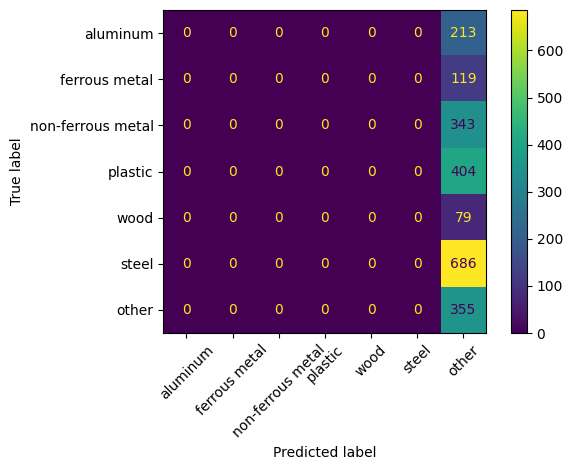

                   precision    recall  f1-score   support

         aluminum       0.00      0.00      0.00       213
    ferrous metal       0.00      0.00      0.00       119
non-ferrous metal       0.00      0.00      0.00       343
            other       0.16      1.00      0.28       355
          plastic       0.00      0.00      0.00       404
            steel       0.00      0.00      0.00       686
             wood       0.00      0.00      0.00        79

         accuracy                           0.16      2199
        macro avg       0.02      0.14      0.04      2199
     weighted avg       0.03      0.16      0.04      2199



C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
classes = ['aluminum', 'ferrous metal', 'non-ferrous metal', 'plastic', 'wood', 'steel', 'other']
show_confusion_matrix(materials_processed, predicted_materials_processed, classes)
print(classification_report(materials_processed, predicted_materials_processed))

## Conclusion
From the results we can see that the model is not doing very well.
It achieves an accuracy of 0.26.
From the confusion matrix we can see that most of the bodies are classified as `other`.

This approach could be further improved by changing the prompt, providing more contextual information to the LLM, and many more ways.
We look forward to seeing your solutions!